## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils


In [2]:
# set constants and hyperparameters

DATASET = 'data/error_win.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [3]:
# import time series

x = pd.read_csv(DATASET)

# x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S", dayfirst=True)
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

temp = x['temperature']
# temp = temp[temp>=18]
# temp = temp.resample('H').mean()

train = temp[(temp.index.year>=2022)]
# test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

Number of time stamps: 113
First 3 time stamps: 2023-01-06 17:20:39, 2023-01-06 17:23:42, 2023-01-06 17:46:36
Last 3 time stamps: 2023-01-07 15:25:23, 2023-01-07 15:47:47, 2023-01-07 15:51:37


time
2023-01-06 17:20:39    21.7
2023-01-06 17:23:42    22.5
2023-01-06 17:46:36    22.5
2023-01-06 17:46:51    21.5
2023-01-06 18:09:31    22.5
Name: temperature, dtype: float64

## Prepare Training Data


In [4]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.new_apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

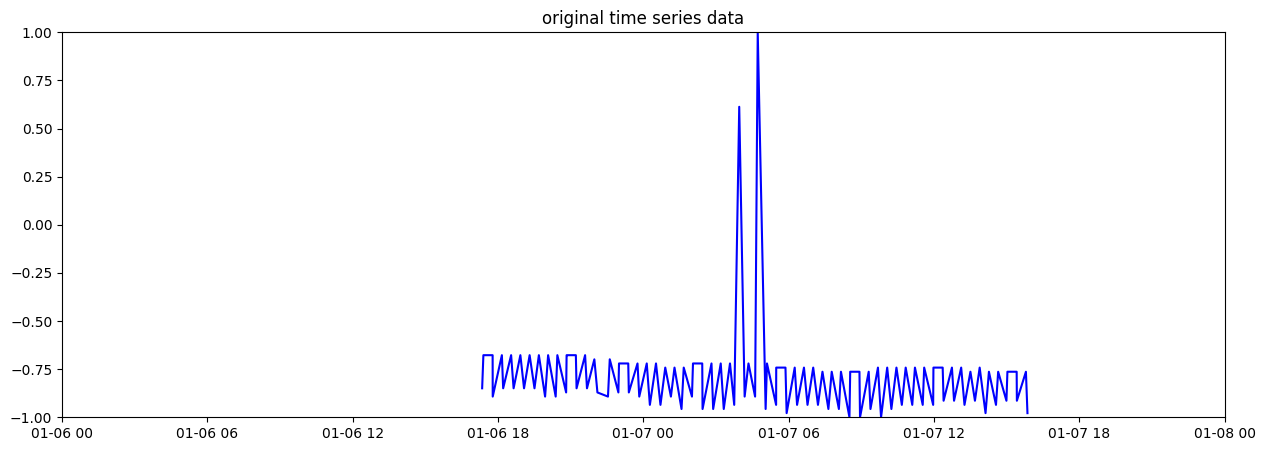

In [15]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2023-01-06', '2023-01-08'], value_range=[-1, 1],
                       title='original time series data')

In [6]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 14
Start times of the first 3 windows: ['2023-01-06T17:20:39.000000000' '2023-01-06T17:23:42.000000000'
 '2023-01-06T17:46:36.000000000']


## Train Reconstruction Model (TadGAN)

In [7]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [8]:
model.get_model("./model/model_tran_100_quy1_3m")

In [17]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)
print(x_win_recon)
print(len(x_win_recon))
print(x_win_recon[0])
np.savetxt("foo.csv", x_win_recon, delimiter=",")

[[-0.77506447 -0.5073701  -0.80473715 ... -0.7561506  -0.5766035
  -0.63812506]
 [-0.7730137  -0.50769067 -0.8033823  ... -0.75535697 -0.57551837
  -0.63695467]
 [-0.7751395  -0.5075666  -0.8046549  ... -0.7580477  -0.5788891
  -0.64047873]
 ...
 [-0.7728586  -0.5110034  -0.8031466  ... -0.76297134 -0.58515257
  -0.64660066]
 [-0.7698516  -0.51152664 -0.8008403  ... -0.762095   -0.583994
  -0.6450909 ]
 [-0.7718646  -0.5105706  -0.8025723  ... -0.76399374 -0.5865079
  -0.6477117 ]]
14
[-0.77506447 -0.5073701  -0.80473715 -0.5969894  -0.7067451  -0.7189938
 -0.7493627  -0.6986494  -0.6342658  -0.8132522  -0.69279987 -0.7489804
 -0.75150645 -0.7608077  -0.6716529  -0.81910217 -0.70323277 -0.75764865
 -0.7878691  -0.7086543  -0.6956095  -0.8004149  -0.62217915 -0.7769262
 -0.66846436 -0.7423455  -0.76357067 -0.6289693  -0.7476853  -0.6741029
 -0.5257626  -0.7701149  -0.48291105 -0.6844392  -0.5774785  -0.67382747
 -0.6795169  -0.50907665 -0.79548407 -0.39524263 -0.8051471  -0.5087417
 -0.

: 

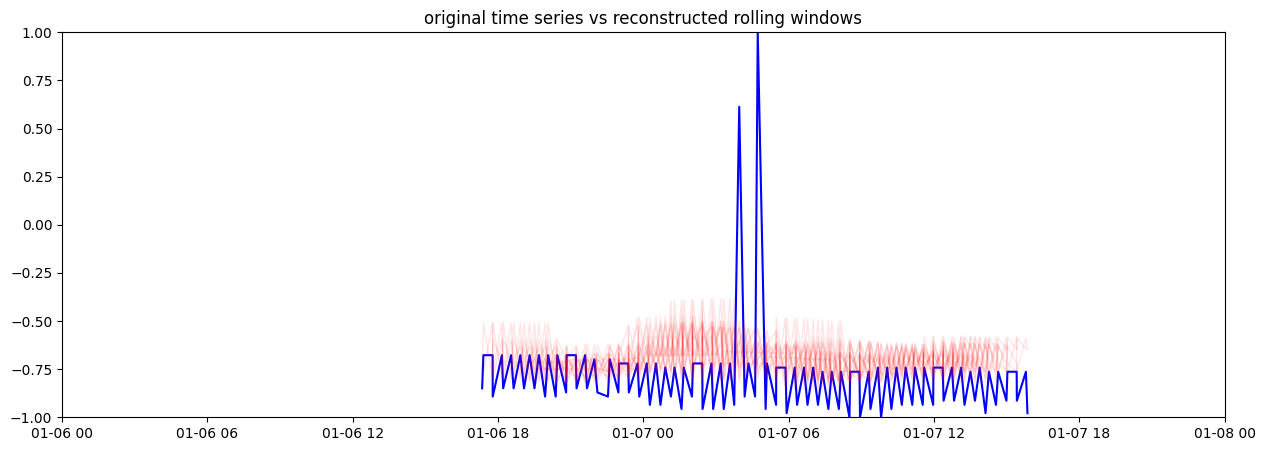

In [16]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2023-01-06', '2023-01-08'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [11]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
print(detected_intervals)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

[-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
                start                 end      score
0 2023-01-06 17:20:39 2023-01-07 15:51:37  12.214416
1 2023-02-06 02:13:53 2023-02-06 22:00:51   4.006461
2 2023-02-11 05:52:35 2023-02-12 03:20:12   8.356626
3 2023-03-27 05:34:06 2023-03-27 21:25:27   4.171982


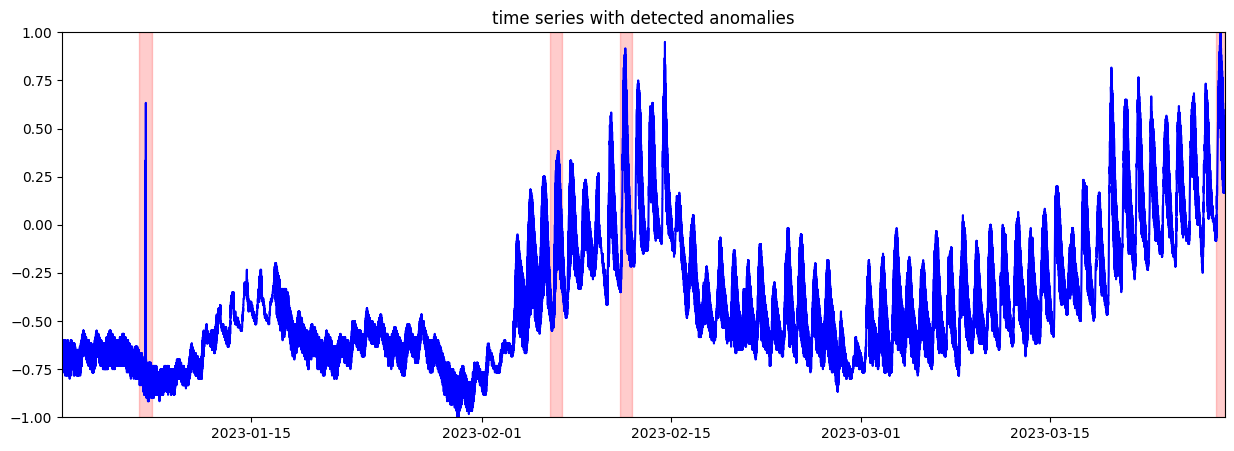

In [12]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [17]:
x_reconstructed_scaled = preprocessing.inverse_rolling_windows(x_win_recon)
x_reconstructed = preprocessing.inverse_scale_data(x_reconstructed_scaled)

print('x_reconstructed',x_reconstructed)

x_reconstructed [-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
